# Analysis of TCGA breast cancer dataset

In [18]:
import spfa 
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler
from muon import MuData

In [9]:
torch.manual_seed(0)

In [41]:
# read data
rna = pd.read_csv("data/tcga_data/train_rna.csv", index_col=0)
mirna = pd.read_csv("data/tcga_data/train_mirna.csv", index_col=0)
prot = pd.read_csv("data/tcga_data/train_prot.csv", index_col=0)
meth = pd.read_csv("data/tcga_data/train_meth.csv", index_col=0)
subtype = pd.read_csv("data/tcga_data/train_y.csv", index_col=0)

# scale and center train data 
scaler = StandardScaler()
rna = pd.DataFrame(scaler.fit_transform(rna), columns = rna.columns)
meth = pd.DataFrame(scaler.fit_transform(meth), columns = meth.columns)
mirna = pd.DataFrame(scaler.fit_transform(mirna), columns = mirna.columns)
prot = pd.DataFrame(scaler.fit_transform(prot), columns = prot.columns)

# all views have gaussian distribution
data = [rna, meth, mirna, prot]
llh = ["gaussian", "gaussian", "gaussian", "gaussian"]
views = ["mrna", "methylation", "mirna", "proteomics"]


In [ ]:

adata = [spfa.tl.get_ad(data[i], llh[i]) for i in range(len(data))]
Xmdata = MuData({views[i]:adata[i] for i in range(len(adata))})
Xmdata

In [43]:
subtype_ad = spfa.tl.get_ad(subtype, "multinomial")
Ymdata = MuData({"subtype":subtype_ad})

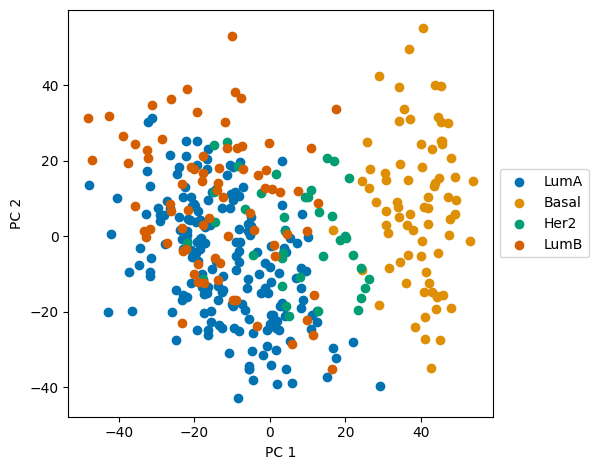

In [22]:

# convert string labels to numeric
label_map = {lab:i for i,lab in enumerate(np.unique(subtype["x"]))}
y = np.array([label_map[i] for i in subtype["x"]])

# define colors for target classes
cblind_colors = sns.color_palette("colorblind", as_cmap=True)[0:4]
subtypes = ["LumA", "Basal",  "Her2", "LumB"]

# plot pca of concatenated views
pca = PCA(2).fit_transform(np.hstack(data))
fig, ax = plt.subplots(1)
for i,sub in enumerate(subtypes):
    plot = ax.scatter(pca[subtype["x"].values==sub,0],pca[subtype["x"].values==sub,1], color=cblind_colors[i], label=sub)
ax.set_aspect('equal')
ax.set_aspect('equal')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()


In [46]:
num_factors = 5
design = np.zeros((len(Ymdata.mod), num_factors))
design[0,0:2] = 1
design

array([[1., 1., 0., 0., 0.]])

In [58]:
# set up model and fit
model = spfa.spFA(Xmdata, 
            num_factors=5, 
            Ymdata=Ymdata, 
            design= torch.tensor(design),
            device=torch.device('cpu'),
            ard=True,
            horseshoe=True)

/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/spfa/models/spFA.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mask.append(torch.tensor(self.Ymdata.mod[i].obsm["mask"]).to(self.device))


In [65]:
model.fit(n_steps=1000, lr=0.01)


  0%|          | 0/1000 [00:00<?, ?it/s]

Current Elbo 2.37E+06 | Delta: 112596: 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]


In [66]:
plt.semilogy(model.history)
plt.show()
plt.close()

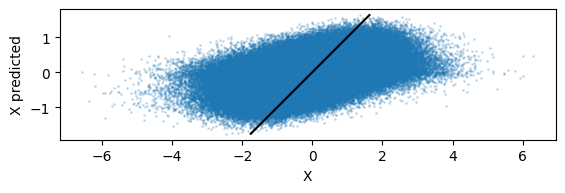

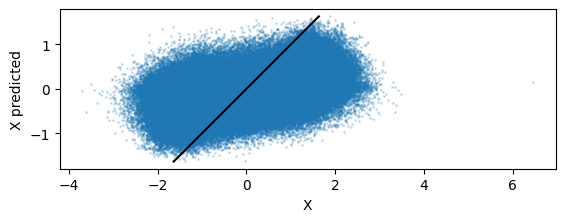

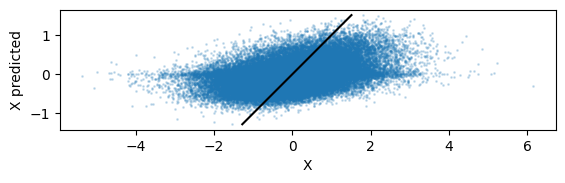

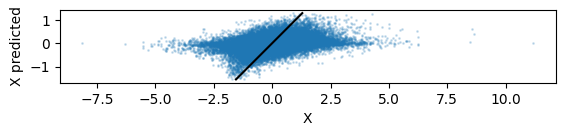

In [70]:
# plot fits
spfa.pl.plot_fit(model, view=0)
plt.show()
plt.close()
spfa.pl.plot_fit(model, view=1)
plt.show()
plt.close()
spfa.pl.plot_fit(model, view=2)
plt.show()
plt.close()
spfa.pl.plot_fit(model, view=3)
plt.show()
plt.close()

/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

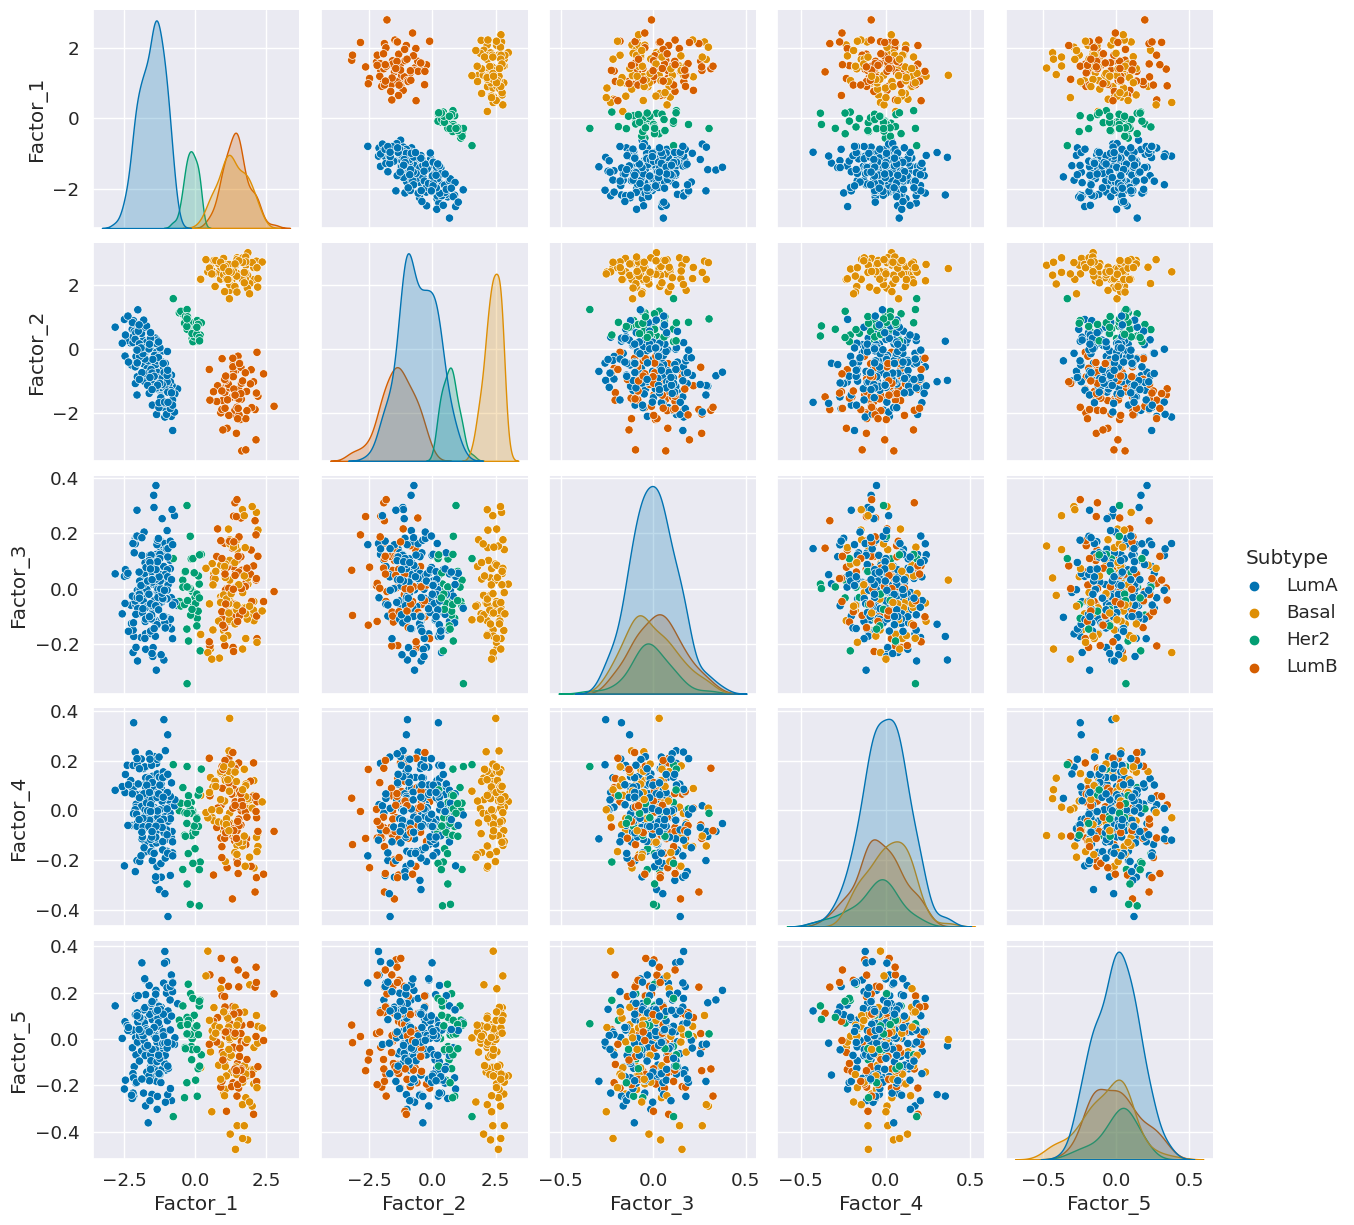

In [71]:
Z_pred = model.Z

df = pd.DataFrame(Z_pred, columns=[f"Factor_{i+1}" for i in range(Z_pred.shape[1])])
df["Subtype"] = subtype["x"].values

# pair plot of all factors colored according to subtype
sns.set(font_scale=1.2)
sns.pairplot(df, vars=df.columns[:-1], hue="Subtype", palette="colorblind")
plt.show()
plt.close()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/spfa/plots/plots.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (x[i], W_sorted[i]))


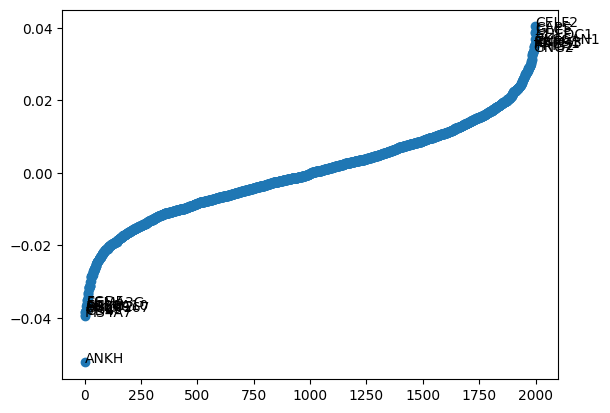

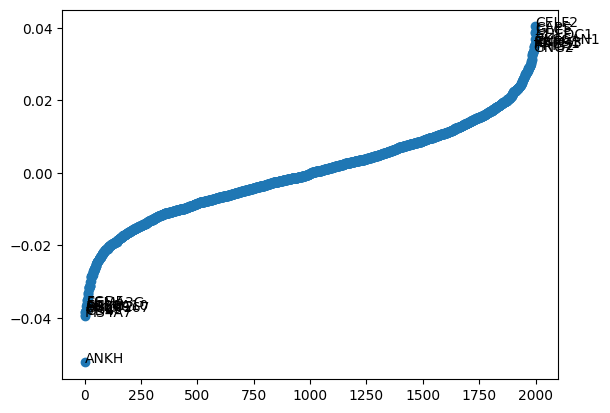

In [75]:

spfa.pl.plot_weights(model, view=0, factor=4)
plt.show()


/home/tuemay/anaconda3/envs/spFA/lib/python3.11/site-packages/spfa/plots/plots.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate("+", (topW[i]+signoffset,i+0.7), fontsize=12)


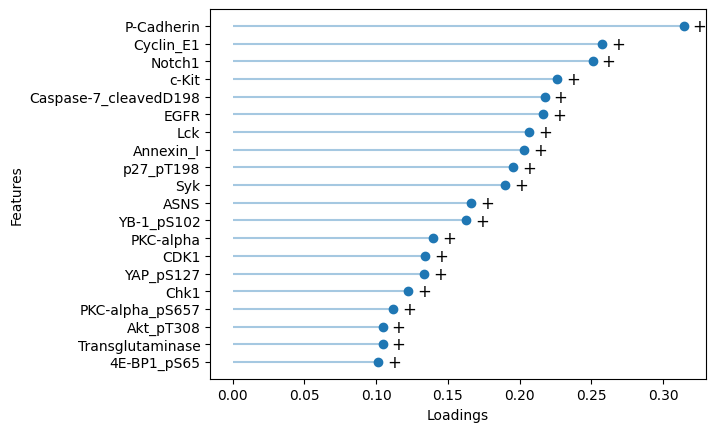

In [83]:
# plot top 20 weights of factor 1 and proteomics data (factor 0 corresponds to the first factor)
spfa.pl.plot_top_weights(model, view=3, factor=1,top_n=20 ,sign="+")
plt.show()

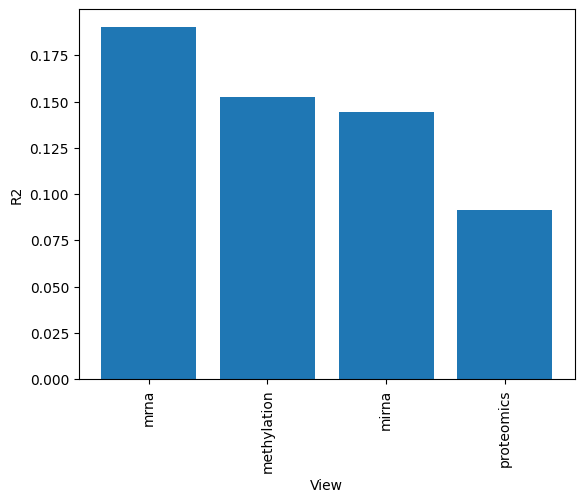

In [88]:

spfa.pl.plot_variance_explained_view(model)
plt.show()


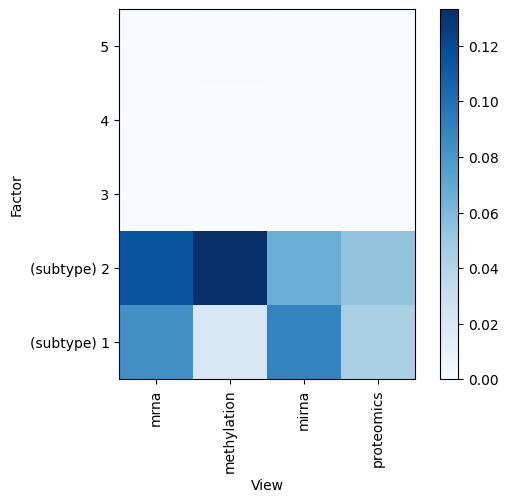

In [130]:

spfa.pl.plot_variance_explained(model)
plt.show()
